In [6]:
import torch
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
import torchmetrics as tm
import os
import argparse
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image


In [19]:

# ----- Model -----
class AgeEstimationModel(nn.Module):
    def __init__(self, input_dim, output_nodes, model_name, pretrain_weights):
        super(AgeEstimationModel, self).__init__()
        from torchvision.models import resnet, efficientnet_b0

        if model_name == 'resnet':
            self.model = resnet.resnet50(weights=pretrain_weights)
            self.model.fc = nn.Sequential(
                nn.Dropout(p=0.2, inplace=True),
                nn.Linear(2048, 256),
                nn.Linear(256, output_nodes)
            )
        elif model_name == 'efficientnet':
            self.model = efficientnet_b0()
            self.model.classifier = nn.Sequential(
                nn.Dropout(p=0.2, inplace=True),
                nn.Linear(1280, 256),
                nn.Linear(256, output_nodes)
            )
        else:
            raise ValueError(f"Unsupported model name: {model_name}")

    def forward(self, x):
        return self.model(x)


In [27]:
from torchvision import transforms

class UTKDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        one_row = self.data.iloc[idx].values
        img_dir = os.path.join(self.root_dir, one_row[0])

        image = Image.open(img_dir).convert('RGB')

        # If no transform is provided, convert the image to tensor manually
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        age = torch.tensor([one_row[1]], dtype=torch.float32)

        gender = one_row[2]
        ethnicity = one_row[3]

        return image, age, gender, ethnicity

In [28]:

# ----- Training Loop -----
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, device, epoch=1, total_epochs=20):
    model.train()
    loss_train = AverageMeter()
    metric.reset()
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{total_epochs}", bar_format='{desc:<16}{percentage:3.0f}%|{bar:70}{r_bar}') as loader:
        for inputs, targets, _, _ in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train.update(loss.item(), n=len(targets))
            metric.update(outputs, targets)
            loader.set_postfix(loss=loss_train.avg, metric=metric.compute().item())
    torch.cuda.empty_cache()
    return model, loss_train.avg, metric.compute().item()

def validation(model, valid_loader, loss_fn, metric, device):
    model.eval()
    loss_valid = AverageMeter()
    metric.reset()
    with tqdm(valid_loader, unit="batch", desc="Evaluating... ", bar_format='{desc:<16}{percentage:3.0f}%|{bar:70}{r_bar}') as loader:
        with torch.no_grad():
            for inputs, targets, _, _ in loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                loss_valid.update(loss.item(), n=len(targets))
                metric.update(outputs, targets)
    torch.cuda.empty_cache()
    return loss_valid.avg, metric.compute().item()

In [ ]:
from sklearn.model_selection import train_test_split
# ----- Loaders -----
def get_loaders(csv_path, root_dir):
    df = pd.read_csv(csv_path)
    df_train, df_valid = train_test_split(df, train_size=0.8, random_state=42)
    df_train, df_valid = train_test_split(df_train, train_size=0.85, random_state=42)

    # Save train and validation sets
    df_train.to_csv('./train_set.csv', index=False)
    df_valid.to_csv('./valid_set.csv', index=False)

    # Define datasets
    train_set = UTKDataset(root_dir, './train_set.csv')
    valid_set = UTKDataset(root_dir, './valid_set.csv')

    # Define dataloaders
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)

    return train_loader, valid_loader


csv_path = 'face.csv'
root_dir = 'crop_part1'
train_loader, valid_loader = get_loaders(csv_path,root_dir)

In [30]:
# ----- Setup -----
os.makedirs('checkpoints', exist_ok=True)
model = AgeEstimationModel(3, 1, 'resnet', 'IMAGENET1K_V2').to("cpu")
loss_fn = nn.L1Loss()
metric = tm.MeanAbsoluteError().to("cpu")
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

writer = SummaryWriter()
best_loss = torch.inf
loss_train_hist, loss_valid_hist = [], []
metric_train_hist, metric_valid_hist = [], []
best_model_path = None

In [ ]:
# ----- Training Loop -----
for epoch in range(20):
    model, loss_train, metric_train = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, "cpu", epoch,20)
    loss_valid, metric_valid = validation(model, valid_loader, loss_fn, metric, "cpu")

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)

    if loss_valid < best_loss:
        best_loss = loss_valid
        if best_model_path:
            os.remove(best_model_path)
        best_model_path = f'checkpoints/epoch-{epoch}-loss_valid-{best_loss:.3}.pt'
        torch.save(model.state_dict(), best_model_path)
        print(f"\nModel saved at epoch {epoch}")

    writer.add_scalar("Loss/train", loss_train, epoch)
    writer.add_scalar("Loss/val", loss_valid, epoch)

    if epoch % 5 == 0:
        print(f"\nEpoch {epoch} - Train Loss: {loss_train:.3}, Valid Loss: {loss_valid:.3}\n")

writer.close()


Evaluating...   100%|██████████████████████████████████████████████████████████████████████| 36/36 [01:09<00:00,  1.93s/batch]



Model saved at epoch 0

Epoch 0 - Train Loss: 11.2, Valid Loss: 8.54



Evaluating...   100%|██████████████████████████████████████████████████████████████████████| 36/36 [00:49<00:00,  1.37s/batch]



Model saved at epoch 1


Epoch 3/5         1%|█                                                                     | 3/202 [00:14<16:08,  4.87s/batch, loss=6.27, metric=6.27]


KeyboardInterrupt: 

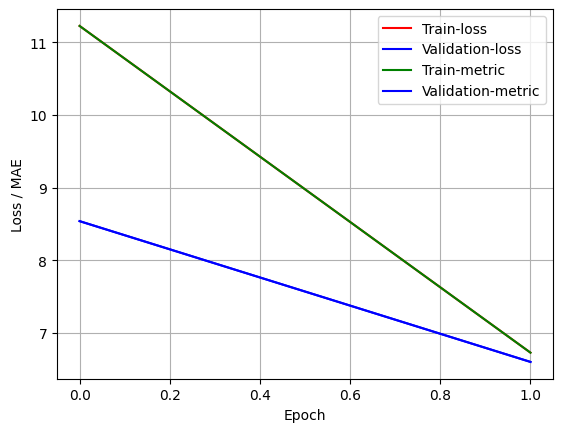

In [ ]:
# ----- Plot -----
os.makedirs('figs', exist_ok=True)
plt.plot(range(20), loss_train_hist, 'r-', label='Train-loss')
plt.plot(range(20), loss_valid_hist, 'b-', label='Validation-loss')
plt.plot(range(20), metric_train_hist, 'g-', label='Train-metric')
plt.plot(range(20), metric_valid_hist, 'b-', label='Validation-metric')
plt.xlabel('Epoch')
plt.ylabel('Loss / MAE')
plt.grid(True)
plt.legend()
plt.savefig('./figs/metric_plot.png')